## Setup

NOTE: All dependencies are within a conda environment to ensure reproducibility. To install all dependencies: pip install -r requirements.txt

In [1]:
import tensorflow.compat.v1 as tf
#Lets see if tensorflow finds the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# import tensorflow as tf

2023-05-11 16:59:12.199165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 16:59:12.239037: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  1


2023-05-11 16:59:13.069013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-11 16:59:13.083771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-11 16:59:13.083900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# #Lets see if it works
tf.ones(1) + tf.ones(1)

2023-05-11 16:59:13.087785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 16:59:13.088637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-11 16:59:13.088752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-11 16:59:13.088823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative val

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>

In [3]:
import numpy as np # for working with arrays and matrices
import pandas as pd # for data manipulation and analysis
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for data visualization
import time # for time-related functions
import random # for random number generation
import cv2 # for computer vision and image processing tasks
import datetime # for saving date and time information
import csv # for loading csv files


import h5py # for working with HDF5 (Hierarchical Data Format) files
import boto3 # for working with Amazon Web Services (AWS)
from pynwb import NWBHDF5IO # for working with Neurodata Without Border (NWB) files
import fsspec 
from fsspec.implementations.cached import CachingFileSystem # library used for working with various file systems in Python.
import requests 
import aiohttp # libraries which are used for making HTTP requests in Python.
import os # OS module provides various operating system-related functions to the code
import pickle
import re


# used for splitting data into training and testing sets in Python.
from sklearn.model_selection import train_test_split 


from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model
import imgaug.augmenters as iaa

import importlib

# # Loading functions
from load_calcium_video import load_video_data, load_one_video
from pixel_values_normalization import normalize_video
from align_behavior_to_calcium import align_files_old_labels, align_files_new_labels
from class_balance import check_class_imbalance_old, check_class_imbalance_new 
from model_architecture import construct_model
from preprocessing_model import model_preprocessing
from run_model import model_execution
from save_model_info import save_training_info
from plots import plot_first_frames, plot_random_frames, plot_image_pixel_values
from send_email_when_code_is_run import send_email
import run_k_fold_model


from urllib.parse import urlparse
from ann_visualizer.visualize import ann_viz
import sys
sys.path.append('/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3')
from nwb_data_generator import NWBDataGeneratorTime

# sklearn
from sklearn.model_selection import KFold
import h5py



In [4]:
comment = "k-fold-cross validation, one video, old (25) labels, new architecture"
experiment_ID = '3.6'
data_file = 'Animal3Learnday11'
experiment_name = str(data_file)+"_"+str(experiment_ID)
train_test_split_strategy = "k-fold"
name = 'BPNN_V3'
model_version = str(name)+'_1'
%store experiment_ID

Stored 'experiment_ID' (str)


In [5]:
# Which labels am I using? Old or New?
labels_type = 'new' # or 'old'

In [6]:
# Which architecture am I using 
architecture_type = 'standard' # or 'old'

In [7]:
# Shuffle data? This to find chance performance
shuffled_labels = False

In [8]:
# am i analysing multiple videos or only one?
multiple_videos = False 

In [9]:
# Define the name of the output directory
output_dir = "output"

# Check if the output directory already exists
if not os.path.exists(output_dir):
    # Create the output directory
    os.mkdir(output_dir)

    # Create the balance, accuracy, loss, and cm directories inside the output directory
    os.mkdir(os.path.join(output_dir, "balance"))
    os.mkdir(os.path.join(output_dir, "accuracy"))
    os.mkdir(os.path.join(output_dir, "loss"))
    os.mkdir(os.path.join(output_dir, "cm"))
    os.mkdir(os.path.join(output_dir, "architecture"))
    os.mkdir(os.path.join(output_dir, "pickles"))
else:
    print(f"The directory {output_dir} already exists.")

The directory output already exists.


### Loading Calcium Videos

In [10]:
video_name_list = []
video_data_list = []

if multiple_videos == True:
    # paths to videos
    video_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.nwb", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.nwb", 
                   "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.nwb"]
    # load the CSV file with the FOV information
    fov_info = pd.read_csv('/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/aligned_videos_animal3.csv')
    images = load_video_data(video_paths, fov_info, video_name_list, video_data_list)

else:
    # paths to videos
    video_path = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211028_181307_animal3learnday11.nwb"]
    images = load_one_video(video_path, video_name_list, video_data_list)

20211028_181307_animal3learnday11.nwb recording_20211028_181307-PP-BP-MC
(24589, 393, 444)


In [11]:
# min_frame = np.min(video_data, axis=0)
# video_data = video_data - min_frame

In [12]:
# images = normalize_video(video_data)

In [13]:
images[0].shape

(393, 444)

In [14]:
# Check if the video has been loaded correctly
images[:1]

array([[[175, 181, 182, ..., 181, 181, 180],
        [170, 174, 173, ..., 177, 176, 179],
        [175, 175, 168, ..., 180, 176, 178],
        ...,
        [180, 182, 175, ..., 170, 173, 167],
        [177, 188, 181, ..., 177, 179, 180],
        [184, 184, 183, ..., 188, 182, 174]]], dtype=int16)

In [15]:
# Determine the size of the calcium video dataset
num_of_frames = images.shape[0]
img_height = images.shape[1]
img_width = images.shape[2]
print("The number of video frames is ", num_of_frames, " and the frame dimensions (height x width) are: ", img_height, "X", img_width)

The number of video frames is  24589  and the frame dimensions (height x width) are:  393 X 444


### Load Labels

In [16]:
num_of_videos = 1



if multiple_videos == False:
    
    bonsai_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-28T18_13_23.csv"]
    
    if labels_type == 'old':
        behavior_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211028_181307_animal3learnday11.h5"]
        df_new_annotations, df_new_annotations_check = align_files_old_labels(bonsai_paths, behavior_paths, num_of_videos)


    else:
        h5_path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/behavior_segmentation_arrowmaze.h5"
        df_new_annotations, df_new_annotations_check = align_files_new_labels(bonsai_paths, num_of_videos, h5_path)

else:
    bonsai_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-25T18_48_49.csv", 
               "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-26T14_29_27.csv", 
               "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-27T16_50_53.csv"]
    
    if labels_type == 'old':


        behavior_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.h5", 
                       "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.h5", 
                       "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.h5"]

        df_new_annotations, df_new_annotations_check = align_files_old_labels(bonsai_paths, behavior_paths, num_of_videos)


    else:
        h5_path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/behavior_segmentation_arrowmaze.h5"
        df_new_annotations, df_new_annotations_check = align_files_new_labels(bonsai_paths, num_of_videos, h5_path)

In [17]:
df_new_annotations

0        0
1        0
2        0
3        0
4        0
        ..
24584    3
24585    3
24586    3
24587    3
24588    3
Name: state_id, Length: 24589, dtype: object

In [18]:
df_new_annotations_check.drop_duplicates()

,state_id,state_name
0,0,grooming
34,2,still
55,1,immobile
108,5,leftTurn
131,3,moving
166,4,rightTurn


In [19]:
# h5_path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/behavior_segmentation_arrowmaze.h5"

In [20]:
# df_new_annotations, df_new_annotations_unique = align_files(bonsai_paths, behavior_paths, num_of_videos, h5_path)
# df_new_annotations, df_new_annotations_unique = align_files(bonsai_paths, num_of_videos, h5_path)

### Aligning Behavior with Calcium video

In [21]:
df_new_annotations = df_new_annotations.reset_index(drop=True)
df_new_annotations_unique = df_new_annotations.unique()

In [22]:
len(df_new_annotations_unique)

6

In [23]:
# class_counts = pd.value_counts(df_new_annotations)
# total_counts = class_counts[0] + class_counts[1] + class_counts[2] + class_counts[3] + class_counts[4] + class_counts[5]

In [24]:
# total_counts

In [25]:
# class_percents = pd.value_counts(df_new_annotations, normalize=True) * 100

In [26]:
# class_percents

In [27]:
df_new_annotations

0        0
1        0
2        0
3        0
4        0
        ..
24584    3
24585    3
24586    3
24587    3
24588    3
Name: state_id, Length: 24589, dtype: object

In [28]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/output/balance"

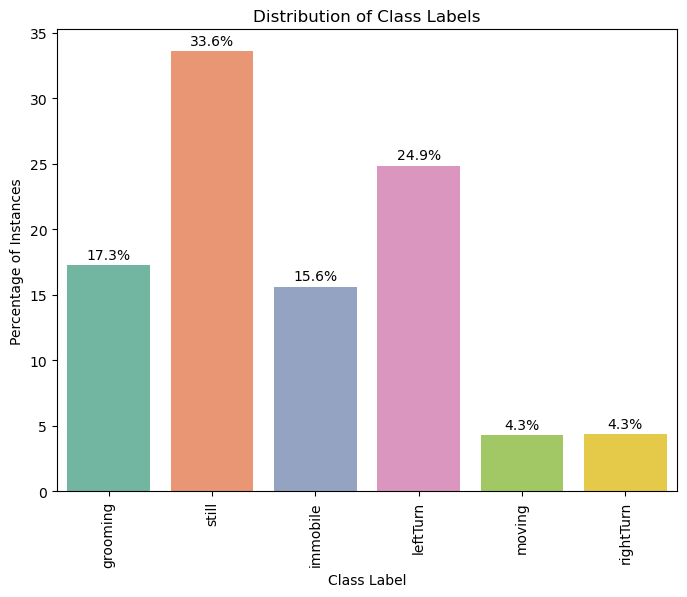

In [29]:
if labels_type == 'new':
    class_counts, total_counts = check_class_imbalance_new(df_new_annotations, experiment_ID, save_dir, df_new_annotations_unique, df_new_annotations_check)
else:
    class_counts, total_counts = check_class_imbalance_old(df_new_annotations, experiment_ID, save_dir, df_new_annotations_unique, df_new_annotations_check)

### Preparing for K-fold

In [ ]:
# Training Parameters
# channel_dimension = 1
labels = df_new_annotations
epochs = 1
# batch_size = 8

In [ ]:
labels

#### Data Verification

In [ ]:
# train_images, val_images, train_labels, val_labels, num_classes = model_preprocessing(train_images, val_images, train_labels, val_labels, df_new_annotations_unique)
vmin = images.min()
vmax = images.max()
plot_first_frames(images, labels, vmin, vmax, data_file)
plot_random_frames(images, labels, vmin, vmax, data_file)

In [ ]:
channel_dimension = 3
input_shape = (img_height, img_width, channel_dimension)
input_shape

In [ ]:
labels

In [ ]:
images, labels, num_classes = model_preprocessing(images, labels, df_new_annotations_unique)

### Starting K-fold

In [ ]:
def start_model(params):
        # start clock
        start_time = time.time()


        # Initialize lists to store the training and validation loss and accuracy values for each fold
        train_loss_all = []
        val_loss_all = []
        train_acc_all = []
        val_acc_all = []
        average_score_list = []

        

        train_loss_all, val_loss_all, train_acc_all, val_acc_all, average_score_list, conf_matrices = run_k_fold_model.run_k_fold(params,
                                                                                                  train_loss_all,
                                                                                                  val_loss_all,
                                                                                                  train_acc_all,
                                                                                                  val_acc_all,
                                                                                                  average_score_list,
                                                                                                  experiment_ID)

        total_accuracy_score = np.mean(average_score_list)

        # end clock
        end_time = time.time()
        execution_time = end_time - start_time
        hours, remainder = divmod(execution_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"Execution time: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")
        print("Total average accuracy score: {:.3f}".format(total_accuracy_score))

In [ ]:
# set number of folds
num_folds = 5 # 10
shuffle = False


if labels_type == 'old':

    no_of_behaviors = ['Main Corr', 'Left Corr', 'Right Corr']
    
    if shuffled_labels == False:

        params = {
                'images': images,
                'labels': labels,
                'number_of_folds': num_folds,
                'shuffle_data': shuffle,
                'input_shape': input_shape,
                'number_of_classes': num_classes,
                'model_name': name,
                'epochs': epochs,
                'behaviours': no_of_behaviors,
                'df_new_annotations': df_new_annotations
            }

        train_loss_all, val_loss_all, train_acc_all, val_acc_all, average_score_list, conf_matrices = start_model(params)

    else:

        # shuffled_labels = np.random.permutation(labels)

        shuffled_labels = np.roll(labels, 15000, axis=0)

        params = {
            'images': images,
            'labels': shuffled_labels,
            'number_of_folds': num_folds,
            'shuffle_data': shuffle,
            'input_shape': input_shape,
            'number_of_classes': num_classes,
            'model_name': name,
            'epochs': epochs,
            'behaviours': no_of_behaviors,
            'df_new_annotations': df_new_annotations
        }

        train_loss_all, val_loss_all, train_acc_all, val_acc_all, average_score_list, conf_matrices = start_model(params)

        
else:
    
    no_of_behaviors = ['Grooming', 'Immobile', 'Still', 'Moving', 'Right Turn', 'Left Turn']
    
    if shuffled_labels == False:

        params = {
                'images': images,
                'labels': labels,
                'number_of_folds': num_folds,
                'shuffle_data': shuffle,
                'input_shape': input_shape,
                'number_of_classes': num_classes,
                'model_name': name,
                'epochs': epochs,
                'behaviours': no_of_behaviors,
                'df_new_annotations': df_new_annotations
            }

        train_loss_all, val_loss_all, train_acc_all, val_acc_all, average_score_list, conf_matrices = start_model(params)

    else:
        
        
        no_of_behaviors = ['Grooming', 'Immobile', 'Still', 'Moving', 'Right Turn', 'Left Turn']

        # shuffled_labels = np.random.permutation(labels)

        shuffled_labels = np.roll(labels, 15000, axis=0)

        params = {
            'images': images,
            'labels': shuffled_labels,
            'number_of_folds': num_folds,
            'shuffle_data': shuffle,
            'input_shape': input_shape,
            'number_of_classes': num_classes,
            'model_name': name,
            'epochs': epochs,
            'behaviours': no_of_behaviors,
            'df_new_annotations': df_new_annotations
        }

        train_loss_all, val_loss_all, train_acc_all, val_acc_all, average_score_list, conf_matrices = start_model(params)


In [ ]:
# model = construct_model(input_shape, num_classes, name)
# Plot the model's architecture to a file
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
%store train_loss_all
%store val_loss_all
%store train_acc_all
%store val_acc_all
%store epochs
%store total_accuracy_score
%store num_folds
%store conf_matrices
%store num_folds

In [ ]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/output/"

In [ ]:
# %store model
# %store history
%store name
%store comment
%store experiment_ID
%store save_dir
%store model_version

In [ ]:
# average_score = np.mean(val_acc_all)

In [ ]:
# average_score

In [ ]:
# # Plot training and validation accuracy for each fold
# plt.figure(figsize=(4, 3))
# for i in range(num_folds):
#     plt.plot(train_acc_all[i], label=f'Train Acc Fold {i+1}')
#     plt.plot(val_acc_all[i], label=f'Val Acc Fold {i+1}')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.savefig('Training-and-Validation-Accuracy.svg', bbox_inches='tight', dpi=300)
# plt.show()

In [ ]:
# # Plot training and validation loss for each fold
# for i in range(num_folds):
#     plt.plot(train_loss_all[i], label=f'Train Loss Fold {i+1}')
#     plt.plot(val_loss_all[i], label=f'Val Loss Fold {i+1}')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.savefig('Training-and-Validation-Loss.svg', bbox_inches='tight', dpi=300)
# plt.show()

In [ ]:
# SAVE ALL HISTORIES IN PICKLE AND LOAD FROM THE OTHER PIPELINE

In [ ]:
# # Save the history object to a pickle file
# with open('All_histories.pkl', 'wb') as f:
#     pickle.dump(all_histories.history, f)

## Method without K-fold

### Data Pre-processing

In [ ]:
# # Split the data into training and validation sets
split_index = int(0.2 * len(images))  # Index to split data

# images = np.concatenate([images, images, images], axis=-1)

val_images, train_images = images[:split_index], images[split_index:]
val_labels, train_labels = labels[:split_index], labels[split_index:]

In [ ]:
check_distribution_among_datasets(val_labels, experiment_ID, save_dir, dataset_type = 'Validation_set')
check_distribution_among_datasets(train_labels, experiment_ID, save_dir, dataset_type = 'Training_set')

In [ ]:
train_images, val_images, train_labels, val_labels, num_classes = model_preprocessing(train_images, val_images, train_labels, val_labels, df_new_annotations_unique)

In [ ]:
# Split the data into training and validation sets
# train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
vmin = 0
vmax = 0.20

In [ ]:
# # Plot the first 5 random images
plot_first_frames(train_images, train_labels, vmin, vmax)
plot_first_frames(val_images, val_labels, vmin, vmax)

In [ ]:
plot_random_frames(train_images, train_labels, vmin, vmax)
plot_random_frames(val_images, val_labels, vmin, vmax)

In [ ]:
train_images, val_images, train_labels, val_labels, num_classes = model_preprocessing(train_images, val_images, train_labels, val_labels, df_new_annotations_unique)

In [ ]:
check_distribution_among_datasets(val_labels, experiment_ID, save_dir, dataset_type = 'Validation_set')
check_distribution_among_datasets(train_labels, experiment_ID, save_dir, dataset_type = 'Training_set')

In [ ]:
input_shape = (img_height, img_width, channel_dimension)

In [ ]:
model = construct_model(input_shape, num_classes, name)

In [ ]:
validation_data=(val_images, val_labels)

In [ ]:
params = {
    'model': model,
    'tf': tf,
    'train_images': train_images,
    'train_labels': train_labels,
    'epochs': epochs,
    'batch_size': batch_size,
    'validation_data': validation_data,
    'val_images': validation_data[0],
    'val_labels': validation_data[1]
}

In [ ]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/output/pickles"


In [ ]:
history = model_execution(params, save_dir, model_version)

#### Data Augmentation

In [ ]:
# # Perform data augmentation
# # Define the augmentation pipeline
# augmentation_pipeline = iaa.Sequential([
#     iaa.Fliplr(0.5), # flip horizontally with a probability of 0.5
#     iaa.Crop(percent=(0, 0.1)), # crop by up to 10% of the image width/height
#     iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))), # apply Gaussian blur with a probability of 0.5
#     # iaa.Affine(rotate=(-10, 10)) # rotate by up to 10 degrees
# ])

In [ ]:
# # Apply the augmentation pipeline to the training set
# augmented_train_images = []
# for image in train_images:
#     # Apply the same augmentation operation to both the image and its corresponding annotation
#     augmented_image = augmentation_pipeline(image=image)
#     augmented_train_images.append(augmented_image)


In [ ]:
# # Convert the augmented training set back to numpy arrays
# train_images = np.array(augmented_train_images)

In [ ]:
# plot_random_frames(train_images, labels)

### Build Model

In [ ]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(model, legend=True)
# # Define the directory name and the plot name
# dir_name = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/output/architecture"
# plot_name = f"{model_version}_architecture"
# ann_viz(model, view=True, filename=plot_name, title="CNN — "+str(name)+" — Simple Architecture")
# plot_path = os.path.join(dir_name, f"{plot_name}.png")
# plot = plt.gcf()
# plot.savefig(plot_path, dpi=300, bbox_inches="tight")

In [ ]:
# from ann_visualizer.visualize import ann_viz
# ann_viz(model, view=True, filename="cconstruct_model", title="CNN — Model 1 — Simple Architecture")

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR')

In [ ]:
# changes grayscale to rgb

In [ ]:
validation_data=(val_images, val_labels)

### Train Model

We have 24186 images of dimensions 349x374 and the number 1 demonstrates that images are grayscale.

In [ ]:
params = {
    'model': model,
    'tf': tf,
    'train_images': train_images,
    'train_labels': train_labels,
    'epochs': epochs,
    'batch_size': batch_size,
    'validation_data': validation_data,
    'val_images': validation_data[0],
    'val_labels': validation_data[1]
}

In [ ]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/output/pickles"

In [ ]:
# # Call the send_email function after your model has finished training
# sender_email = 'guskikala@gmail.com'
# recipient_email = 'guskikala@gmail.com'
# subject = 'CNN Model Training Completed'
# message = 'Your CNN model training is complete!'

# send_email(sender_email, recipient_email, subject, message)

### Save results

In [ ]:
%store model
%store history
%store name
%store comment
%store experiment_ID
%store save_dir
%store model_version

In [ ]:
#save_training_info(model, history, video_name, comment, experiment_ID, save_dir, f1_score=f1_score)

High bias: If the training accuracy is low, it suggests that the model is underfitting the training data, i.e., it is not complex enough to capture the patterns in the data. In this case, you may need to increase the model's complexity by adding more layers or neurons, or by using a more complex architecture.

High variance: If the training accuracy is high but the validation accuracy is low, it suggests that the model is overfitting the training data, i.e., it is memorizing the training data instead of generalizing to new data. In this case, you may need to use regularization techniques like dropout or L2 regularization, or use early stopping to prevent the model from overfitting.

Good fit: If the training accuracy and validation accuracy are both high and close to each other, it suggests that the model is neither underfitting nor overfitting the data, i.e., it is generalizing well to new data.

Plateauing: If the validation accuracy is no longer increasing as the training set size or epochs increase, it suggests that the model has reached its capacity and adding more data or epochs is unlikely to improve its performance.

In general, a model accuracy curve can help you diagnose issues with your model and guide you in selecting appropriate strategies to improve its performance. It can also give you an idea of how much training data or how many epochs you need to achieve good performance.

### Reflect on the results

1. Insufficient data? One calcium video of 24186 frames and with 349x374 dimensions.
2. Model architecture not appropriate. Try increasing the number of layers or filters, or adding more complex layers like BatchNormalization, Dropout, or Conv2DTranspose.
3. Incorrect data preprocessing
4. Incorrect hyperparameters
5. Class Imbalance (do oversampling, or undersampling)

### [Ignore for now]

## Reusable snippets

In [ ]:
# Load calcium video from local environment
# with h5py.File('path', 'r') as f:
#     video_data = np.array(f['analysis/recording_20211016_163921-PP-BP-MC/data'])

In [ ]:
# Loading locally
# with h5py.File('/Users/konstantinoskalaitzidis/Developer/dmc/thesis_data/20211016_163921_animal1learnday1.h5', 'r') as f:
#     print(list(f.keys()))
#     behavior_data = np.array(f['per_frame'])

In [ ]:
# # save the model architecture to a JSON file
# with open('model_architecture.json', 'w') as f:
#     f.write(model.to_json())

In [ ]:
# # load the model architecture from the JSON file
# with open('model_architecture.json', 'r') as f:
#     json_string = f.read()

# model_json = model_from_json(json_string)

# # print the loaded model summary
# model.summary()

In [ ]:
# mySession = readSessionServer.SessionIterator()
# sess = mySession.findSession()
# # for sess in mySession.findSessions():
# #     print(sess)
# if sess.hasBehavior() and sess.hasCalcium():
#     behavior = sess.getBehaviorSegmentation(align_with_calcium=True).reset_index()

## [Ignore for now] Define hyperparameters

In [ ]:
# IMG_SIZE = 224
# BATCH_SIZE = 64
# EPOCHS = 10

# MAX_SEQ_LENGTH = 20
# NUM_FEATURES = 2048

In [ ]:
# import sys
# sys.path.append("/Users/konstantinoskalaitzidis/Developer/dmc")
# from readSessionsServer import SessionIterator

#TODO: Script to retrieve videos from a list of calcium videos (of the same animal) from the db

## Dataset preparation and label annotation (feature engineering)

### [Ignore for now] Data availale for processing - overview

The following is not going to be used for now but will allow us to have an overview of all the videos I have available to train my CNN model. I expect to have all recordings sessions for each animal as input for the CNN which is going to be trained only based on recordings from the corresponding animal. The data will be split to train/test at some point...

In [ ]:
# train_df = pd.read_csv("train.csv")
# test_df = pd.read_csv("test.csv")

# print(f"Total videos for training: {len(train_df)}")
# print(f"Total videos for testing: {len(test_df)}")

# train_df.sample(10)

Extract frames from the calcium imaging video and save to directory. Each frame contains spatial information, and the sequence of those frames contains temporal information (the latter is not exploited for now). Maybe also ask for path input from the user to make it reproducible for others.

Helpful source: https://keras.io/examples/vision/video_classification/

The number of frames may differ from video to video.
The frame rate may also differ from video to video but it should be 20fps for all. 

The duration of each frame depends on the frame rate of the video. If a video has a frame rate of 25 fps, then each frame will have a duration of 1/25th of a second, or approximately 0.04 seconds. The calcium videos use 20fps, while the behavioral recordings are at 60fps. Alignment of these videos will follow shortly. 

### [Ignore for now] Fetch all calcium videos from the dmc database and align calcium videos with behavior annotations

In [ ]:
# mySession = readSessionServer.SessionIterator()
# for sess in mySession.findSessions():
#     print(sess)
    # if sess.hasBehavior() and sess.hasCalcium():
        # behavior = sess.getBehaviorSegmentation(align_with_calcium=True).reset_index()

### [Ignore for now] Open calcium video locally, create dir for saving frames and count number of frames with OpenCV

In [ ]:
# Open the HDF5 file
# with h5py.File('/Users/konstantinoskalaitzidis/Developer/dmc/thesis_data/20211016_163921_animal1learnday1.nwb', 'r') as f:
#     # Print the keys of the file
#     print(list(f.keys()))
#     # dataset = f['identifier'][()]
#     # print(dataset)

In [ ]:
# Directory where frames from video will be stored after extraction
# frames_dir = "path"

In [ ]:
# Open the video using OpenCV and count the number of frames
# cap = cv2.VideoCapture(raw_calcium_video_path)
# frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# cap.release()

# print(f"Number of frames in the video: {frame_count}")

In [ ]:
# video = 'path'

# cap = cv2.VideoCapture(video)
# frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# cap.release()

# print(f"Number of frames in the video: {frame_count}")

In [ ]:
# Open the video file
# cap = cv2.VideoCapture(video)

# # Get the frame rate of the video
# frame_rate = int(cap.get(cv2.CAP_PROP_FPS))

# # Release the video capture object
# cap.release()

# print(f"Frame rate of the video: {frame_rate}")

In [ ]:
# save each frame as one image

In [ ]:
# cap = cv2.VideoCapture(video)

# # Loop through the video frames and save each one as an image file
# frame_count = 0
# while(cap.isOpened()):
#     ret, frame = cap.read()
#     if ret == False:
#         break
#     # Save the frame as an image file
#     frame_file = os.path.join(frames_dir, "frame_" + str(frame_count) + ".jpg")
#     cv2.imwrite(frame_file, frame)
#     frame_count += 1

# # Close the video file
# cap.release()

In [ ]:
# # define paths
# video_path = '/Users/konstantinoskalaitzidis/Developer/dmc/thesis_data/20211016_163921_animal1learnday1.nwb'
# train_dir = '/Users/konstantinoskalaitzidis/Developer/dmc/thesis_data/train'
# test_dir = '/Users/konstantinoskalaitzidis/Developer/dmc/thesis_data/test'

# # define train-test split ratio
# train_test_ratio = 0.8

# # open video file
# cap = cv2.VideoCapture(video_path)

# # get video frame count
# frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# # create list of frame indices
# frame_indices = list(range(frame_count))

# # shuffle frame indices
# random.shuffle(frame_indices)

# # split frame indices into train and test sets
# train_frame_indices = frame_indices[:int(frame_count * train_test_ratio)]
# test_frame_indices = frame_indices[int(frame_count * train_test_ratio):]

# # iterate over frames and save to train or test directory
# for i in range(frame_count):
#     # read frame
#     ret, frame = cap.read()
#     if not ret:
#         break
    
#     # save frame to train or test directory
#     if i in train_frame_indices:
#         cv2.imwrite(os.path.join(train_dir, f'{i}.jpg'), frame)
#     else:
#         cv2.imwrite(os.path.join(test_dir, f'{i}.jpg'), frame)